# Piano Playalong Generation from MIDI


Main Notebook to train an autoregressive Transformer model (GPT-2) on MIDI data.

### Imports

In [2]:
import numpy as np
import pandas as pd
import os
import json
from pathlib import Path
from tqdm import tqdm
import random
import torch
from torch import nn, optim
from torch.utils.data import Dataset, ConcatDataset, DataLoader, random_split
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import lightning as L
# necessary cuda version on your system
print(torch.version.cuda)

#!pip install partitura miditok transformers[torch]

from torch.nn import functional as F
from transformers import GPT2LMHeadModel, AutoConfig, Trainer, TrainingArguments
from transformers.optimization import AdamW 
from transformers import pipeline, GenerationConfig, EarlyStoppingCallback


import partitura as pt
from miditok import Structured, TokenizerConfig
from miditok.data_augmentation import augment_dataset
from miditok.pytorch_data import DatasetMIDI, DataCollator
from miditok.pytorch_data import split_files_for_training
#!pip install pretty_midi jupyterlab fluidsynth
#!sudo apt-get install fluidsynth # you need program as well as package - see pretty-midi github
#!pip install pyFluidSynth
import fluidsynth
import pretty_midi 
from IPython.display import Audio
#!pip install wandb

import os
import scipy.io.wavfile as wavfile
#!pip install soundfile
#import soundfile as sf
import matplotlib.pyplot as plt
# seed random module
L.seed_everything(21)


Seed set to 21


None


21

### Logging

In [ ]:
import wandb 
wandb.login(key="") # enter your wandb key if you want to use logging.


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: s-sonderegger. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/seb/.netrc


True

## Tokenization

We use the MIDITok Structured Tokenizer to create Tokens from our MIDI files:

https://miditok.readthedocs.io/




### Create Tokenizer
Using the "Structured"-Tokenizer from MidiTok, read the docs to understand parameters.

In [3]:
# parameters
TOKENIZER_PARAMS = {
    "pitch_range": (21, 109),
    "beat_res": {(0, 4): 16, (4, 12): 4}, #time resolution per beat of first bar, and of second to third bar (max pause is 3 bars) 
    "num_velocities": 32,
    "special_tokens": ["PAD", "BOS", "EOS", "MASK"],
    "use_chords": False,
    "use_rests": False,
    "use_tempos": False,
    "use_time_signatures": False,
    "use_pitchdrum_tokens": False,
    "use_programs": False,
}
# Set to True if you want to use BPE
USE_BPE = False

config = TokenizerConfig(**TOKENIZER_PARAMS)

# Creates the tokenizer
tokenizer = Structured(config)
"Vocab size:", len(tokenizer)
tokenizer.vocab

/tmp/ipykernel_1122168/1717783542.py:17: UserWarning: The special token PAD_None is present twice in your configuration. Skipping its duplicated occurrence.
  config = TokenizerConfig(**TOKENIZER_PARAMS)


{'PAD_None': 0,
 'BOS_None': 1,
 'EOS_None': 2,
 'MASK_None': 3,
 'Pitch_21': 4,
 'Pitch_22': 5,
 'Pitch_23': 6,
 'Pitch_24': 7,
 'Pitch_25': 8,
 'Pitch_26': 9,
 'Pitch_27': 10,
 'Pitch_28': 11,
 'Pitch_29': 12,
 'Pitch_30': 13,
 'Pitch_31': 14,
 'Pitch_32': 15,
 'Pitch_33': 16,
 'Pitch_34': 17,
 'Pitch_35': 18,
 'Pitch_36': 19,
 'Pitch_37': 20,
 'Pitch_38': 21,
 'Pitch_39': 22,
 'Pitch_40': 23,
 'Pitch_41': 24,
 'Pitch_42': 25,
 'Pitch_43': 26,
 'Pitch_44': 27,
 'Pitch_45': 28,
 'Pitch_46': 29,
 'Pitch_47': 30,
 'Pitch_48': 31,
 'Pitch_49': 32,
 'Pitch_50': 33,
 'Pitch_51': 34,
 'Pitch_52': 35,
 'Pitch_53': 36,
 'Pitch_54': 37,
 'Pitch_55': 38,
 'Pitch_56': 39,
 'Pitch_57': 40,
 'Pitch_58': 41,
 'Pitch_59': 42,
 'Pitch_60': 43,
 'Pitch_61': 44,
 'Pitch_62': 45,
 'Pitch_63': 46,
 'Pitch_64': 47,
 'Pitch_65': 48,
 'Pitch_66': 49,
 'Pitch_67': 50,
 'Pitch_68': 51,
 'Pitch_69': 52,
 'Pitch_70': 53,
 'Pitch_71': 54,
 'Pitch_72': 55,
 'Pitch_73': 56,
 'Pitch_74': 57,
 'Pitch_75': 58,
 'Pitc

### Load data and tokenize
Here you can filter out Midi-files you want to exclude (e.g. Tuning Tracks - Use lookup.json file to inspect data)

In [4]:
midi_paths = list(Path("data").glob("**/*.mid"))
lookup_path = Path("data", "lookup.json")

# files to exclude:
idx_del = []
lookup = json.loads(lookup_path.read_text())
midi_paths_cleaned = [] 
# files containing this string will be excluded
lookup_str = "tuning"
for key, title in lookup.items():
    if lookup_str in title.lower():
        idx_del.append(key)
    # manually specify keys to exclude 
    elif str(key) in ["0021","0361","0362","0814","0313","0330","0655","1217","1266"]:   # verbal instructions, tuning and whole cds that couldnt be converted to midi (too long)
        idx_del.append(key)
    else:
        #exclude empty files
        #if not len(tokenizer(Path("data","midis", str(key)+".mid"))[0])>10:
        #    idx_del.append(key)
        #else:
        if str(key) not in ["0182","0194","0230","0410","0460"]: # test set
            midi_paths_cleaned.append(Path("data","midis", str(key)+".mid"))
        

print(f"Loaded {len(midi_paths_cleaned)} valid files, {len(idx_del)} invalid files and 5 testfiles excluded.")


Loaded 1249 valid files, 61 invalid files and 5 testfiles excluded.


In [5]:
tokenizer_path = Path("data", "tokenizer", "tokenizer.json")

# load tokenizer if it already exists
if os.path.exists(tokenizer_path):
    tokenizer = Structured(params=tokenizer_path)

else:    
    # Builds the vocabulary with BPE
    if USE_BPE:
        print(f"Learning BPE...")
        tokenizer.learn_bpe(vocab_size=300, files_paths=midi_paths_cleaned)
        print(f"Saving tokenizer with BPE to {tokenizer_path}")
        tokenizer.save_params(tokenizer_path)
        print("Finished.")
    # Saves tokenizer without BPE
    else:
        print(f"Saving tokenizer to {tokenizer_path}")
        tokenizer.save_params(tokenizer_path)
        print("Done.")


/home/seb/miniconda3/envs/bac/lib/python3.11/site-packages/miditok/midi_tokenizer.py:3252: UserWarning: The special token PAD_None is present twice in your configuration. Skipping its duplicated occurrence.
  self.config = TokenizerConfig()
/home/seb/miniconda3/envs/bac/lib/python3.11/site-packages/miditok/classes.py:702: UserWarning: The special token PAD_None is present twice in your configuration. Skipping its duplicated occurrence.
  return cls(**input_dict, **kwargs)


In [6]:
midi_paths_cleaned[0]  # print example midi path

PosixPath('data/midis/0001.mid')

## Get data statistics

In [7]:
from partitura import load_performance_midi
score = load_performance_midi(midi_paths_cleaned[0])
# Get the duration of the MIDI file in seconds

print("Number of notes in the MIDI file:", len(score.note_array()))
score.note_array()[-1]

Number of notes in the MIDI file: 2188


(219.03645, 3.1432292, 168220, 2414, 71, 28, 0, 0, 'n2187')

Duration of MIDI file: 39.029947916666664 - 813.9388020833333 secs.
Average Duration of MIDI file: 318.6544944288766 secs.
Average Number of notes per MIDI file: 3161.082465972778 notes.


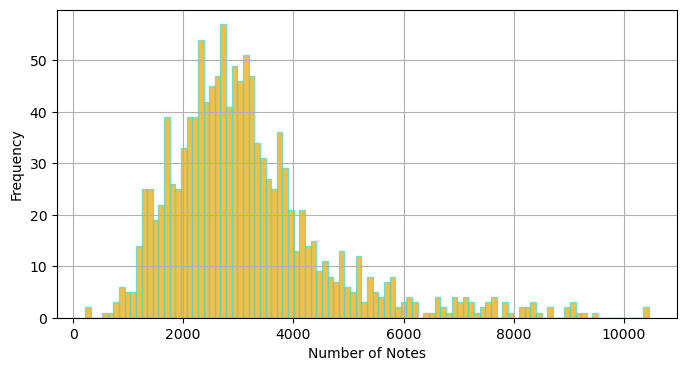

In [8]:
# get midi statistics:
midi_lens = []
midi_durs = []
for midi in midi_paths_cleaned:
    midi_data = pretty_midi.PrettyMIDI(str(midi))
    dur = midi_data.get_end_time()
    if dur < 20:
        print("Too Short: ", midi)
    midi_durs.append(dur)

    num_notes = 0
    for instrument in midi_data.instruments:
        num_notes += len(instrument.notes)
    if num_notes < 200:
        print("Few notes:", midi)
    midi_lens.append(num_notes)

print(f"Duration of MIDI file: {min(midi_durs)} - {max(midi_durs)} secs.")
print(f"Average Duration of MIDI file: {sum(midi_durs)/len(midi_durs)} secs.")  
print(f"Average Number of notes per MIDI file: {sum(midi_lens)/len(midi_lens)} notes.")  
plt.figure(figsize=(8, 4))
plt.hist(midi_lens, bins=100, alpha=0.75, color='orange', edgecolor='turquoise')
#plt.title(f'MIDI-Notes per piece')
plt.xlabel('Number of Notes')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


    

In [10]:
midi = tokenizer(midi_paths_cleaned[0])
len(midi[0]),midi

(8752,
 [TokSequence(tokens=['TimeShift_8.0.4', 'Pitch_74', 'Velocity_71', 'Duration_0.5.16', 'TimeShift_0.0.1', 'Pitch_62', 'Velocity_67', 'Duration_0.4.16', 'TimeShift_0.0.1', 'Pitch_67', 'Velocity_63', 'Duration_0.5.16', 'TimeShift_0.0.1', 'Pitch_76', 'Velocity_67', 'Duration_0.5.16', 'TimeShift_0.1.16', 'Pitch_52', 'Velocity_63', 'Duration_0.4.16', 'TimeShift_0.0.1', 'Pitch_57', 'Velocity_67', 'Duration_0.4.16', 'TimeShift_0.0.1', 'Pitch_69', 'Velocity_67', 'Duration_0.5.16', 'TimeShift_0.0.1', 'Pitch_71', 'Velocity_67', 'Duration_0.4.16', 'TimeShift_0.0.1', 'Pitch_72', 'Velocity_67', 'Duration_0.4.16', 'TimeShift_0.9.16', 'Pitch_62', 'Velocity_67', 'Duration_2.0.16', 'TimeShift_0.0.1', 'Pitch_74', 'Velocity_67', 'Duration_3.8.16', 'TimeShift_0.0.1', 'Pitch_67', 'Velocity_67', 'Duration_1.15.16', 'TimeShift_0.0.1', 'Pitch_76', 'Velocity_63', 'Duration_3.8.16', 'TimeShift_0.0.1', 'Pitch_57', 'Velocity_67', 'Duration_3.7.16', 'TimeShift_0.0.1', 'Pitch_69', 'Velocity_67', 'Duration_3.

## Split MIDIs into subsequences
Again, consult the MIDITok-docs to understand the parameters.

In [30]:
# Split MIDIs into smaller chunks for training
MAX_MIDI_LENGTH = 300 # ~ up to twice the number of tokens when tokenized
MIN_SEQ_LENGTH = 0
AUGMENT_DATA = False
OVERLAP = 1
BOS_ONLY = False
dataset_chunks_dir = Path("data", "midi_chunks")

if not os.path.exists(dataset_chunks_dir) or not os.listdir(dataset_chunks_dir):
    midi_paths_chunks = split_files_for_training(
        files_paths=[path.resolve() for path in midi_paths_cleaned], # function needs absolute paths
        tokenizer=tokenizer,
        save_dir=dataset_chunks_dir,
        max_seq_len=MAX_MIDI_LENGTH,
        #average_num_tokens_per_note=4,
        num_overlap_bars=OVERLAP,
        #min_seq_len=MIN_SEQ_LENGTH,
    )
    if BOS_ONLY:
        for file_path in dataset_chunks_dir.iterdir():
            if file_path.is_file() and not file_path.name.endswith('_0.mid'):
                os.remove(file_path)
        
    if AUGMENT_DATA:
        augment_dataset(
        dataset_chunks_dir,
        pitch_offsets=[-5,-4,-3,-2,-1,1,2,3,4,5,6],
        velocity_offsets=[0],
        duration_offsets=[0],
    )
        

midi_paths_chunks = sorted([Path(p) for p in dataset_chunks_dir.iterdir() if p.is_file()])[1:] #first object is some hidden file
midi_paths_chunks

Splitting music files (data/midi_chunks): 100%|██████████| 1249/1249 [00:13<00:00, 95.72it/s]


[PosixPath('data/midi_chunks/0001_0.mid'),
 PosixPath('data/midi_chunks/0001_1.mid'),
 PosixPath('data/midi_chunks/0001_10.mid'),
 PosixPath('data/midi_chunks/0001_11.mid'),
 PosixPath('data/midi_chunks/0001_12.mid'),
 PosixPath('data/midi_chunks/0001_13.mid'),
 PosixPath('data/midi_chunks/0001_14.mid'),
 PosixPath('data/midi_chunks/0001_15.mid'),
 PosixPath('data/midi_chunks/0001_16.mid'),
 PosixPath('data/midi_chunks/0001_17.mid'),
 PosixPath('data/midi_chunks/0001_18.mid'),
 PosixPath('data/midi_chunks/0001_19.mid'),
 PosixPath('data/midi_chunks/0001_2.mid'),
 PosixPath('data/midi_chunks/0001_20.mid'),
 PosixPath('data/midi_chunks/0001_21.mid'),
 PosixPath('data/midi_chunks/0001_22.mid'),
 PosixPath('data/midi_chunks/0001_23.mid'),
 PosixPath('data/midi_chunks/0001_24.mid'),
 PosixPath('data/midi_chunks/0001_25.mid'),
 PosixPath('data/midi_chunks/0001_26.mid'),
 PosixPath('data/midi_chunks/0001_27.mid'),
 PosixPath('data/midi_chunks/0001_28.mid'),
 PosixPath('data/midi_chunks/0001_2

### MIDI-Chunks statistics

In [31]:
# print(f"Number of midi chunks: {len(midi_paths_chunks)}")
# dataset_chunks_bos_only = [path for path in midi_paths_chunks if path.name.endswith("0.mid")]
# print(f"Number of midi chunks, beginnings only: {len(dataset_chunks_start_only)}")


In [32]:
print(len(tokenizer(midi_paths_chunks[0])[0]))
# for i in range(1):
#     if len(tokenizer(midi_paths_chunks[i])[0]) >200:
#         print(i)

324


In [33]:
import math
def get_number_of_bars(midi_path: str) -> int:
    # Load the MIDI file
    midi_data = pretty_midi.PrettyMIDI(str(midi_path))
    
    # Get the initial tempo (assume only one tempo)
    tempo = midi_data.get_tempo_changes()[1][0]
    
    # Get the initial time signature (assume only one time signature)
    if midi_data.time_signature_changes:
        time_signature = midi_data.time_signature_changes[0]
        beats_per_bar = time_signature.numerator
    else:
        beats_per_bar = 4  # Default to 4/4 time signature if none found

    # Get the total length of the MIDI file in seconds
    total_time_seconds = midi_data.get_end_time()
    
    # Convert total time to beats
    total_beats = total_time_seconds * (tempo / 60)
    
    # Calculate the number of bars
    number_of_bars = math.ceil(total_beats / beats_per_bar)
    
    return int(number_of_bars)
get_number_of_bars(str(midi_paths_chunks[2])), midi_paths_chunks[2]

(5, PosixPath('data/midi_chunks/0001_10.mid'))

100%|██████████| 63786/63786 [01:18<00:00, 808.33it/s]


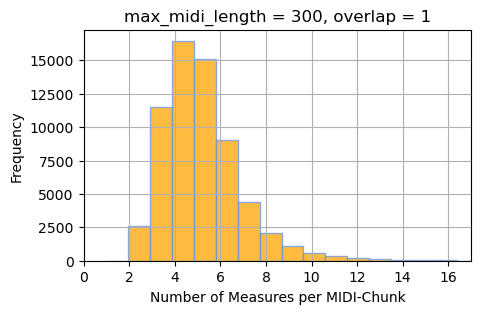

In [34]:
bars = [get_number_of_bars(midi_paths_chunks[i]) for i in tqdm(range(len(midi_paths_chunks)))]
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3))
plt.hist(bars, bins=50, alpha=0.75, color='orange', edgecolor='cornflowerblue')
plt.title(f'max_midi_length = {MAX_MIDI_LENGTH}, overlap = {OVERLAP}')
plt.xlabel('Number of Measures per MIDI-Chunk')
plt.ylabel('Frequency')
plt.xlim((0,17))
plt.grid(True)
-plt.show()

data/inputs/midi_test/four_bars/tournaround_4.mid 216
data/inputs/midi_test/four_bars/cantaloupe_4.mid 476
data/inputs/midi_test/four_bars/sentimental_4.mid 300
data/inputs/midi_test/four_bars/walking_blues_4.mid 136
data/inputs/midi_test/four_bars/one_note_samba_4.mid 256


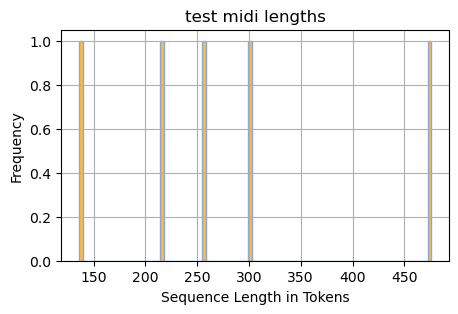

In [17]:
test_midi_paths = [str("data/inputs/midi_test/four_bars/") + f for f in os.listdir("data/inputs/midi_test/four_bars/") if f.endswith("4.mid")]
lengths = [len(tokenizer(test_midi_paths[i])[0]) for i in range(len(test_midi_paths))]
for mid, l in zip(test_midi_paths,lengths):
    print(mid,l)
plt.figure(figsize=(5, 3))
plt.hist(lengths, bins=100, alpha=0.75, color='orange', edgecolor='cornflowerblue')
plt.title(f'test midi lengths')
plt.xlabel('Sequence Length in Tokens')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

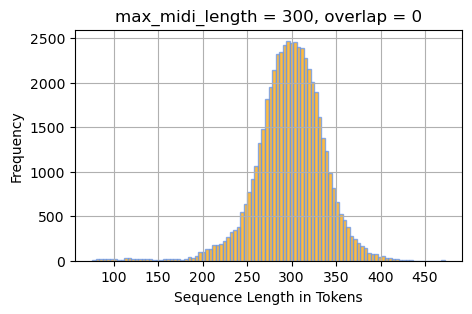

In [30]:
lengths = [len(tokenizer(midi_paths_chunks[i])[0]) for i in range(len(midi_paths_chunks))]
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3))
plt.hist(lengths, bins=100, alpha=0.75, color='orange', edgecolor='cornflowerblue')
plt.title(f'max_midi_length = {MAX_MIDI_LENGTH}, overlap = {OVERLAP}')
plt.xlabel('Sequence Length in Tokens')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
# # command+shift+/

In [22]:
print(f"Total number of files after splitting into chunks: ",len(midi_paths_chunks ))
# create train and validation-set 
val_chunks_paths = midi_paths_chunks [0:len(midi_paths_chunks )//5]
train_chunks_paths = midi_paths_chunks [len(midi_paths_chunks )//5:]

print(f"Size after splitting into train/val : {len(train_chunks_paths)} / {len(val_chunks_paths)}")

Total number of files after splitting into chunks:  16233
Size after splitting into train/val : 12987 / 3246


## Dataloading and Collator
Setup Dataloaders and Collator (also from MIDITok package).

In [23]:
# Load midi chunks into dataset
MAX_SEQUENCE_LENGTH = 300 # 200

dataset_train = DatasetMIDI(
    files_paths=train_chunks_paths,
    max_seq_len=MAX_SEQUENCE_LENGTH,
    tokenizer=tokenizer,
    bos_token_id=tokenizer["BOS_None"],
    eos_token_id=tokenizer["EOS_None"]
)

dataset_val = DatasetMIDI(
    files_paths=val_chunks_paths,
    max_seq_len=MAX_SEQUENCE_LENGTH,
    tokenizer=tokenizer,
    bos_token_id=tokenizer["BOS_None"],
    eos_token_id=tokenizer["EOS_None"]
)
# setup Collator
collator = DataCollator(
    pad_token_id=tokenizer.pad_token_id, pad_on_left=False, copy_inputs_as_labels=True , shift_labels=False) #padding on left is not necessary for gpt2

# Set up dataloader
BS = 10
data_loader_train = DataLoader(dataset=dataset_train, batch_size=BS, collate_fn=collator,shuffle=True, num_workers=4,) #set num workers for faster loading?
data_loader_val = DataLoader(dataset=dataset_val, batch_size=BS, collate_fn=collator,shuffle=True, num_workers=4)
print(f"Dataloader created.")
print(f"N samples in train/val (rounded to BS): {len(data_loader_train)*BS} / {len(data_loader_val)*BS}")

Dataloader created.
N samples in train/val (rounded to BS): 12990 / 3250


In [24]:
# Inspect elements in batch
first_batch = next(iter(data_loader_train))
print(first_batch)
ids = [i for i in first_batch['input_ids']]
lbls = [i for i in first_batch['labels']]
att = [i for i in first_batch['attention_mask']]
for i in zip(ids,lbls,att):
    print(i) 

{'input_ids': tensor([[  1, 302,  44,  ...,   0,   0,   0],
        [  1, 307,  42,  ..., 220,  36, 107],
        [  1, 300,  38,  ..., 221,  45, 102],
        ...,
        [  1, 300,  21,  ...,   0,   0,   0],
        [  1, 299,  34,  ...,   0,   0,   0],
        [  1, 302,  49,  ..., 220,  51, 107]]), 'labels': tensor([[   1,  302,   44,  ..., -100, -100, -100],
        [   1,  307,   42,  ...,  220,   36,  107],
        [   1,  300,   38,  ...,  221,   45,  102],
        ...,
        [   1,  300,   21,  ..., -100, -100, -100],
        [   1,  299,   34,  ..., -100, -100, -100],
        [   1,  302,   49,  ...,  220,   51,  107]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
(tensor([  1, 302,  44, 110, 127, 220,  32, 109, 127, 220,  30, 106, 128, 220,
         34, 107, 127, 

## Training the model

### Transformer model class
We use the GPT-2 transformer. Many other models are available through the huggingface pipeline.

In [25]:
# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)


Device: cuda:0


In [26]:
# load config and setup untrained model of gpt2
config = AutoConfig.from_pretrained("gpt2",vocab_size = len(tokenizer),
                                    bos_token_id = tokenizer["BOS_None"], 
                                    eos_token_id = tokenizer["EOS_None"],
                                    n_layer=16, # linear increase in model size (double = double)
                                    n_head=16,  # no increase in model size but probably training time
                                    n_embd=512, # most impact on model size (exp.)
                                    #n_positions=512, # max context length ,default = 1024, few additional parameters (~1-2%)
                                    #n_ctx = 512, # same as n_positions
                                    )


model = GPT2LMHeadModel(config)
print("Number of Parameters in model:", f'{sum(p.numel() for p in model.parameters())/1e6:.2f}',"M",model.config)

Number of Parameters in model: 51.13 M GPT2Config {
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 1,
  "embd_pdrop": 0.1,
  "eos_token_id": 2,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 512,
  "n_head": 16,
  "n_inner": null,
  "n_layer": 16,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.39.3",
  "use_cache": true,
  "vocab_size": 317
}



In [27]:
run = wandb.init(project="bac",name="bs10-lr1e-5-emb_d-512-len-midi-300-tok16-bos-only-augmented-new")

# set training args
training_args = TrainingArguments(
    output_dir = "./model/gpt-2",
    evaluation_strategy = "steps",
    eval_steps=300,
    eval_accumulation_steps=16,
    save_strategy="steps",
    save_steps=300,
    save_only_model=True, # False to resume training
    greater_is_better=False,
    #auto_find_batch_size=True,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=10,
    num_train_epochs=60,
    learning_rate=1e-5,
    weight_decay=0.2,
    max_grad_norm=10.0,
    gradient_accumulation_steps=2,
    lr_scheduler_type="reduce_lr_on_plateau",
    warmup_ratio=0.025,    
    fp16=True, #only on cuda
    logging_steps=100,
    save_total_limit = 1, # saves only most recent checkpoint
    load_best_model_at_end= True, # + best one 
    report_to="wandb",    
    )

#log model 
log_data= {"model_type" : "gpt-2",
           "model_params": f'{sum(p.numel() for p in model.parameters())/1e6:.3f}M',
           "n_layer": model.config.n_layer,
           "n_head": model.config.n_head,
           "n_embd" : model.config.n_embd,
           "n_ctx" : model.config.n_ctx,
           "batch_size" : training_args.per_device_train_batch_size,
           "lr" : training_args.learning_rate,
           "lr-scheduler": training_args.lr_scheduler_type,
           "num_epochs": training_args.num_train_epochs,
           "weight_decay": training_args.weight_decay,
           "warmup_ratio" : training_args.warmup_ratio,
           "early_stopping_patience" : 3,
           "tokenizer_type": "Structured",
           "overlap" : OVERLAP,
           "pad_on_left" : False,
           "max_seq_length" : MAX_SEQUENCE_LENGTH,
           "augment_data" : False,    
           "max_midi_length" : MAX_MIDI_LENGTH,       
           }
table = wandb.Table(columns=["hp","value"])
for key, value in log_data.items():
    table.add_data(key,str(value))
log_name = f"Training Parameters-{run.name}"
wandb.log({log_name: table})
# setup trainer
trainer = Trainer(
    model=model, 
    tokenizer= tokenizer, 
    args = training_args,
    data_collator=collator,
    train_dataset=dataset_train,
    eval_dataset=dataset_val, 
    callbacks = [EarlyStoppingCallback(early_stopping_patience=2)],
)

# train 
trainer.train()

/home/seb/miniforge3/envs/bac/lib/python3.11/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
  0%|          | 100/38940 [02:44<17:03:09,  1.58s/it]

{'loss': 3.8158, 'grad_norm': 2.677877902984619, 'learning_rate': 1e-05, 'epoch': 0.15}


  1%|          | 200/38940 [05:29<17:53:25,  1.66s/it]

{'loss': 3.3071, 'grad_norm': 2.2426652908325195, 'learning_rate': 1e-05, 'epoch': 0.31}


  1%|          | 300/38940 [08:15<17:49:07,  1.66s/it]

{'loss': 3.1357, 'grad_norm': 2.243366241455078, 'learning_rate': 1e-05, 'epoch': 0.46}


                                                      
  1%|          | 300/38940 [09:46<17:49:07,  1.66s/it]

{'eval_loss': 3.0882515907287598, 'eval_runtime': 90.9709, 'eval_samples_per_second': 35.682, 'eval_steps_per_second': 3.573, 'epoch': 0.46}


  1%|          | 400/38940 [12:29<17:28:59,  1.63s/it] 

{'loss': 3.0267, 'grad_norm': 2.1863110065460205, 'learning_rate': 1e-05, 'epoch': 0.62}


  1%|▏         | 500/38940 [15:13<17:27:25,  1.63s/it]

{'loss': 2.9424, 'grad_norm': 2.7624003887176514, 'learning_rate': 1e-05, 'epoch': 0.77}


  2%|▏         | 600/38940 [17:56<17:26:14,  1.64s/it]

{'loss': 2.8907, 'grad_norm': 3.2162134647369385, 'learning_rate': 1e-05, 'epoch': 0.92}


                                                      
  2%|▏         | 600/38940 [19:27<17:26:14,  1.64s/it]

{'eval_loss': 2.8752238750457764, 'eval_runtime': 91.0591, 'eval_samples_per_second': 35.647, 'eval_steps_per_second': 3.569, 'epoch': 0.92}


  2%|▏         | 700/38940 [22:11<17:21:27,  1.63s/it] 

{'loss': 2.8281, 'grad_norm': 2.6703505516052246, 'learning_rate': 1e-05, 'epoch': 1.08}


  2%|▏         | 800/38940 [24:54<17:18:40,  1.63s/it]

{'loss': 2.7779, 'grad_norm': 2.4123759269714355, 'learning_rate': 1e-05, 'epoch': 1.23}


  2%|▏         | 900/38940 [27:38<17:18:44,  1.64s/it]

{'loss': 2.7276, 'grad_norm': 2.7633800506591797, 'learning_rate': 1e-05, 'epoch': 1.39}


                                                      
  2%|▏         | 900/38940 [29:09<17:18:44,  1.64s/it]

{'eval_loss': 2.7167179584503174, 'eval_runtime': 90.9519, 'eval_samples_per_second': 35.689, 'eval_steps_per_second': 3.573, 'epoch': 1.39}


  3%|▎         | 1000/38940 [31:53<17:15:21,  1.64s/it]

{'loss': 2.6676, 'grad_norm': 2.948640823364258, 'learning_rate': 1e-05, 'epoch': 1.54}


  3%|▎         | 1100/38940 [34:37<17:09:44,  1.63s/it]

{'loss': 2.6259, 'grad_norm': 2.8254268169403076, 'learning_rate': 1e-05, 'epoch': 1.69}


  3%|▎         | 1200/38940 [37:20<17:07:24,  1.63s/it]

{'loss': 2.5759, 'grad_norm': 3.2482242584228516, 'learning_rate': 1e-05, 'epoch': 1.85}


                                                       
  3%|▎         | 1200/38940 [38:51<17:07:24,  1.63s/it]

{'eval_loss': 2.5863611698150635, 'eval_runtime': 90.6566, 'eval_samples_per_second': 35.805, 'eval_steps_per_second': 3.585, 'epoch': 1.85}


  3%|▎         | 1300/38940 [41:34<16:37:35,  1.59s/it] 

{'loss': 2.5365, 'grad_norm': 3.252457857131958, 'learning_rate': 1e-05, 'epoch': 2.0}


  4%|▎         | 1400/38940 [44:18<17:03:40,  1.64s/it]

{'loss': 2.5042, 'grad_norm': 3.6538455486297607, 'learning_rate': 1e-05, 'epoch': 2.16}


  4%|▍         | 1500/38940 [47:02<16:59:54,  1.63s/it]

{'loss': 2.458, 'grad_norm': 3.7730886936187744, 'learning_rate': 1e-05, 'epoch': 2.31}


                                                       
  4%|▍         | 1500/38940 [48:32<16:59:54,  1.63s/it]

{'eval_loss': 2.495175361633301, 'eval_runtime': 90.6864, 'eval_samples_per_second': 35.794, 'eval_steps_per_second': 3.584, 'epoch': 2.31}


  4%|▍         | 1600/38940 [51:17<16:58:31,  1.64s/it] 

{'loss': 2.4374, 'grad_norm': 3.7911510467529297, 'learning_rate': 1e-05, 'epoch': 2.46}


  4%|▍         | 1700/38940 [54:00<16:54:00,  1.63s/it]

{'loss': 2.4169, 'grad_norm': 2.9516875743865967, 'learning_rate': 1e-05, 'epoch': 2.62}


  5%|▍         | 1800/38940 [56:44<16:51:25,  1.63s/it]

{'loss': 2.3855, 'grad_norm': 3.3626205921173096, 'learning_rate': 1e-05, 'epoch': 2.77}


                                                       
  5%|▍         | 1800/38940 [58:14<16:51:25,  1.63s/it]

{'eval_loss': 2.4465270042419434, 'eval_runtime': 90.7222, 'eval_samples_per_second': 35.78, 'eval_steps_per_second': 3.582, 'epoch': 2.77}


  5%|▍         | 1900/38940 [1:00:59<16:53:13,  1.64s/it]

{'loss': 2.372, 'grad_norm': 3.117858648300171, 'learning_rate': 1e-05, 'epoch': 2.93}


  5%|▌         | 2000/38940 [1:03:42<16:45:28,  1.63s/it]

{'loss': 2.3507, 'grad_norm': 4.41023588180542, 'learning_rate': 1e-05, 'epoch': 3.08}


  5%|▌         | 2100/38940 [1:06:26<16:31:43,  1.62s/it]

{'loss': 2.33, 'grad_norm': 3.220675468444824, 'learning_rate': 1e-05, 'epoch': 3.23}


                                                         
  5%|▌         | 2100/38940 [1:07:56<16:31:43,  1.62s/it]

{'eval_loss': 2.4251036643981934, 'eval_runtime': 90.6764, 'eval_samples_per_second': 35.798, 'eval_steps_per_second': 3.584, 'epoch': 3.23}


  6%|▌         | 2200/38940 [1:10:40<16:45:17,  1.64s/it] 

{'loss': 2.3356, 'grad_norm': 3.601665496826172, 'learning_rate': 1e-05, 'epoch': 3.39}


  6%|▌         | 2300/38940 [1:13:24<16:39:53,  1.64s/it]

{'loss': 2.3051, 'grad_norm': 3.5978260040283203, 'learning_rate': 1e-05, 'epoch': 3.54}


  6%|▌         | 2400/38940 [1:16:08<16:33:42,  1.63s/it]

{'loss': 2.2915, 'grad_norm': 3.318230390548706, 'learning_rate': 1e-05, 'epoch': 3.7}


                                                         
  6%|▌         | 2400/38940 [1:17:38<16:33:42,  1.63s/it]

{'eval_loss': 2.4122350215911865, 'eval_runtime': 90.6572, 'eval_samples_per_second': 35.805, 'eval_steps_per_second': 3.585, 'epoch': 3.7}


  6%|▋         | 2500/38940 [1:20:22<16:34:10,  1.64s/it] 

{'loss': 2.2771, 'grad_norm': 3.0263071060180664, 'learning_rate': 1e-05, 'epoch': 3.85}


  7%|▋         | 2600/38940 [1:23:06<16:13:18,  1.61s/it]

{'loss': 2.2763, 'grad_norm': 3.6510069370269775, 'learning_rate': 1e-05, 'epoch': 4.0}


  7%|▋         | 2700/38940 [1:25:53<16:43:47,  1.66s/it]

{'loss': 2.2526, 'grad_norm': 3.6981968879699707, 'learning_rate': 1e-05, 'epoch': 4.16}


                                                         
  7%|▋         | 2700/38940 [1:27:25<16:43:47,  1.66s/it]

{'eval_loss': 2.4109041690826416, 'eval_runtime': 92.8948, 'eval_samples_per_second': 34.943, 'eval_steps_per_second': 3.499, 'epoch': 4.16}


  7%|▋         | 2800/38940 [1:30:13<16:47:13,  1.67s/it] 

{'loss': 2.243, 'grad_norm': 3.9556617736816406, 'learning_rate': 1e-05, 'epoch': 4.31}


  7%|▋         | 2900/38940 [1:33:00<16:48:01,  1.68s/it]

{'loss': 2.2347, 'grad_norm': 4.067454814910889, 'learning_rate': 1e-05, 'epoch': 4.46}


  8%|▊         | 3000/38940 [1:35:46<16:22:41,  1.64s/it]

{'loss': 2.2214, 'grad_norm': 3.5367913246154785, 'learning_rate': 1e-05, 'epoch': 4.62}


                                                         
  8%|▊         | 3000/38940 [1:37:17<16:22:41,  1.64s/it]

{'eval_loss': 2.408364772796631, 'eval_runtime': 90.8096, 'eval_samples_per_second': 35.745, 'eval_steps_per_second': 3.579, 'epoch': 4.62}


  8%|▊         | 3100/38940 [1:40:01<16:15:49,  1.63s/it] 

{'loss': 2.1979, 'grad_norm': 4.596376895904541, 'learning_rate': 1e-05, 'epoch': 4.77}


  8%|▊         | 3200/38940 [1:42:44<16:15:37,  1.64s/it]

{'loss': 2.1956, 'grad_norm': 4.4064621925354, 'learning_rate': 1e-05, 'epoch': 4.93}


  8%|▊         | 3300/38940 [1:45:28<16:14:54,  1.64s/it]

{'loss': 2.1806, 'grad_norm': 3.874744415283203, 'learning_rate': 1e-05, 'epoch': 5.08}


                                                         
  8%|▊         | 3300/38940 [1:47:02<16:14:54,  1.64s/it]

{'eval_loss': 2.4133806228637695, 'eval_runtime': 93.39, 'eval_samples_per_second': 34.757, 'eval_steps_per_second': 3.48, 'epoch': 5.08}


  9%|▊         | 3400/38940 [1:49:50<16:44:46,  1.70s/it] 

{'loss': 2.167, 'grad_norm': 4.356184482574463, 'learning_rate': 1e-05, 'epoch': 5.23}


  9%|▉         | 3476/38940 [1:51:59<16:36:23,  1.69s/it]

KeyboardInterrupt: 

In [28]:
# finish logging
wandb.finish()

## Inference

Test your model with and without inputs and play around with inference parameters.

In [ ]:
model_local = GPT2LMHeadModel.from_pretrained("model/gpt-2/checkpoint-1270")
tokenizer_path = Path("data", "tokenizer", "tokenizer.json")

# load tokenizer if it already exists
if os.path.exists(tokenizer_path):
    tokenizer = Structured(params=tokenizer_path)
    
model_local.eval()
#what to give as input
num_notes = 150
gen_config = GenerationConfig(bos_token_id=1,
                            max_length=(4*num_notes)+1, # +1 for bos token
                            do_sample=True, # False = greedy generation
                            temperature=1.3, # > 1  
                            #top_k = 50,
                            top_p=0.9,  
                            #num_beam_groups=2, 
                            num_beams = 1, # 1 = beam search disabled                         
                            #diversity_penalty= 2.5, # for beam search, needs beam-groups
                            #early_stopping=True, 
                            #repetition_penalty=1.5,
                            #no_repeat_ngram_size=4, # ? no token is ever repeated
                            eos_token_id=2,
                            pad_token_id=0,
                            )
with torch.no_grad():
    out_no_in = model_local.generate(generation_config=gen_config)
print(out_no_in.size(),out_no_in,[tokenizer[i]for i in out_no_in.numpy().flatten().tolist()])

### Inference with inputs

In [ ]:
input_midi = Path("data","inputs","midi_test", "four_bars", "walking_blues_4.mid") # arpeggio_cmaj.mid, I-II-V_fmaj.mid , single_chord_cmaj.mid
input_tokens = tokenizer.encode(input_midi,)
print((input_tokens))
input_tokens = torch.concat((torch.tensor([[1]]),torch.tensor(input_tokens)),dim=1) # prepend bos token
# generate
out_in = model_local.generate(inputs=input_tokens, generation_config=gen_config)


[TokSequence(tokens=['TimeShift_1.12.16', 'Pitch_41', 'Velocity_43', 'Duration_0.3.16', 'TimeShift_0.3.16', 'Pitch_65', 'Velocity_71', 'Duration_3.3.16', 'TimeShift_0.0.1', 'Pitch_62', 'Velocity_71', 'Duration_3.1.16', 'TimeShift_0.0.1', 'Pitch_60', 'Velocity_75', 'Duration_3.3.16', 'TimeShift_0.0.1', 'Pitch_34', 'Velocity_63', 'Duration_0.12.16', 'TimeShift_0.0.1', 'Pitch_56', 'Velocity_67', 'Duration_3.5.16', 'TimeShift_0.13.16', 'Pitch_38', 'Velocity_55', 'Duration_0.12.16', 'TimeShift_0.14.16', 'Pitch_41', 'Velocity_59', 'Duration_0.13.16', 'TimeShift_0.14.16', 'Pitch_40', 'Velocity_59', 'Duration_0.10.16', 'TimeShift_0.10.16', 'Pitch_41', 'Velocity_47', 'Duration_0.2.16', 'TimeShift_0.3.16', 'Pitch_39', 'Velocity_63', 'Duration_0.13.16', 'TimeShift_0.1.16', 'Pitch_65', 'Velocity_63', 'Duration_0.5.16', 'TimeShift_0.0.1', 'Pitch_61', 'Velocity_71', 'Duration_0.4.16', 'TimeShift_0.0.1', 'Pitch_55', 'Velocity_59', 'Duration_0.3.16', 'TimeShift_0.0.1', 'Pitch_58', 'Velocity_51', 'Dura

In [ ]:
print(out_in.size(),out_in,[tokenizer[i]for i in out_in.numpy().flatten().tolist()])

torch.Size([1, 601]) tensor([[  1, 248,  24, 102, 126, 223,  48, 109, 174, 220,  45, 109, 172, 220,
          43, 110, 174, 220,  17, 107, 135, 220,  39, 108, 176, 233,  21, 105,
         135, 234,  24, 106, 136, 234,  23, 106, 133, 230,  24, 103, 125, 223,
          22, 107, 136, 221,  48, 107, 128, 220,  44, 109, 127, 220,  38, 106,
         126, 220,  41, 104, 132, 233,  20, 107, 138, 232,  48, 107, 126, 220,
          44, 109, 127, 220,  38, 107, 125, 223,  19, 106, 136, 233,  18, 107,
         135, 230,  48, 109, 196, 220,  45, 109, 193, 220,  43, 111, 190, 221,
          39, 109, 190, 222,  17, 105, 135, 233,  12, 106, 136, 234,  15, 106,
         139, 235,  19, 106, 136, 232,  18, 107, 126, 222,  17, 107, 136, 234,
          21, 109, 137, 232,  24, 107, 135, 233,  23, 107, 133, 230,  43, 111,
         147, 220,  42, 114, 141, 228,  42, 111, 124, 220,  43, 112, 133, 220,
          50, 112, 147, 220,  43, 112, 147, 231,  17, 109, 160, 220,  45, 111,
         157, 220,  42, 112, 16

## Back to MIDI

Convert your output back to MIDI and listen to it (direct listening only works in Jupyter Lab, not in VSCode)

In [ ]:
#sequence = [[1, 226, 43, 110, 124, 188, 48, 110, 124, 188, 38, 110, 124, 188, 53, 111, 124, 188, 57, 110]]
#print(sequence.tolist())

out = tokenizer.tokens_to_midi(tokens=out_no_in)
print(out.note_num(),out)
fpath = os.path.join("data","example","example.mid")
out.dump_midi(fpath)
midi_data = pretty_midi.PrettyMIDI(midi_file=fpath, initial_tempo=100)
audio_data = midi_data.fluidsynth(fs=44100, sf2_path=os.path.join("data","soundfont","SC55_zzdenis_v0.5.sf2"))
print(len(audio_data),type(audio_data))
wav_path = f"{fpath[:-3]}wav"
wavfile.write(wav_path,44100,audio_data)
audio,sr = sf.read(wav_path)
Audio(audio,rate=sr)



/tmp/ipykernel_203500/4280540331.py:4: UserWarning: miditok: The `tokens_to_midi` method had been renamed `decode`. It is now depreciated and will be removed in future updates.
  out = tokenizer.tokens_to_midi(tokens=out_no_in)


150 Score(ttype=Tick, tpq=16, begin=0, end=922, tracks=1, notes=150, time_sig=1, key_sig=0, markers=0, lyrics=0)
1313354 <class 'numpy.ndarray'>
